In [2]:
import json
from datetime import datetime, time, timedelta
import os
from Powerfleet_APIs_Management import PowerFleetAPIsManager as ApiManager
from colorama import Fore, Style
import sys  # For printing caught exceptions
import re
from Powerfleet_APIs_Management import MongoDBConnector as DBConnector
from pathlib import Path
import pandas as pd
import csv
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import geopandas as gpd
import math
from typing import *
import statistics


Enable plot UI backend

In [1]:
# %matplotlib tk

Update <u>PARAMETERS.json</u> with **current** date and time

In [ ]:
file_path = "PARAMETERS.json" 

# Get the current date and time
current_datetime = datetime.now().strftime("%Y-%m-%d")  # Format as YYYY-MM-DD
current_time = datetime.now().strftime("%H:%M:%S")  # Format as HH:MM:SS

# Check if the file exists and is not empty
if not os.path.exists(file_path):
    print(f"Error: The file '{file_path}' does not exist.")
    exit()

# Check if the file is empty
if os.path.getsize(file_path) == 0:
    print(f"Error: The file '{file_path}' is empty.")
    exit()

# Load the current JSON data
try:
    with open(file_path, "r") as file:
        data = json.load(file)
except json.JSONDecodeError as e:
    print(f"Error: Failed to decode JSON. Details: {e}")
    exit()

# Combine the date and time
combined_datetime = current_datetime + " " + current_time

# Update the 'endDate' field in the 'snapshot_api' section
data["snapshot_api"]["endDate"] = combined_datetime

# Save the updated JSON data back to the file
try:
    with open(file_path, "w") as file:
        json.dump(data, file, indent=4)  # Use indent for readable JSON formatting
    print(f"Updated PARAMETERS.json with: {combined_datetime}.")
except Exception as e:
    print(f"Error: Failed to save the updated file. Details: {e}")


In [ ]:
print(Fore.YELLOW + f"MAIN CWD={os.getcwd()}")
print(f"MAIN, LISTDIR={os.listdir()}" + Style.RESET_ALL)

# Define the ApiParameterExtractor class
class ApiParameterExtractor:
    def __init__(self, json_file):
        with open(json_file, 'r') as file:
            self.parameters = json.load(file)

    def extract_parameters(self, api_type):
        # Normalize API type to lowercase
        api_type = api_type.lower()
        
        # Validate API type
        if api_type not in self.parameters:
            raise ValueError(f"Invalid API type: {api_type}. Valid types are 'live_api' or 'snapshot_api'.")
        
        # Return the corresponding dictionary for the given API type
        return self.parameters[api_type]


extractor = ApiParameterExtractor("PARAMETERS.json")

# Extract parameters for live_api and snapshot_api
live_api_params         = extractor.extract_parameters("live_api")
snapshot_api_params     = extractor.extract_parameters("snapshot_api")

# Pass the extracted parameters to PowerFleetAPIsManager
live_api_manager        = ApiManager(live_api_params)
snapshot_api_manager    = ApiManager(snapshot_api_params)




In [5]:
CONVERT_UNIX_TO_DATE = False

In [ ]:
# === Function to Save DataFrame to CSV ===
def save_to_csv(dataframe, output_dir, file_name):
    """
    Save a DataFrame to a specified CSV file in the given directory.
    
    :param dataframe: The DataFrame to save.
    :param output_dir: The directory where the CSV file will be saved.
    :param file_name: The name of the CSV file (e.g., "file_name.csv").
    """
    if not dataframe.empty:  # Only save if the DataFrame is not empty
        os.makedirs(output_dir, exist_ok=True)  # Ensure the directory exists
        file_path = Path(output_dir) / file_name  # Construct the full file path
        dataframe.to_csv(file_path, index=False)  # Overwrite the CSV file by default
        print(f"Data saved to {file_path}")
    else:
        print(f"No data to save for {file_name}. Skipping...")

# === Function to Convert UNIX Timestamps to Datetime Using Pandas ===
def unix_to_datetime_pandas(dataframe, column_name):
    """
    Convert a UNIX timestamp column to human-readable datetime format.
    
    :param dataframe: The DataFrame containing the column.
    :param column_name: The column name containing UNIX timestamps.
    """
    if column_name in dataframe.columns:
        try:
            dataframe[column_name] = pd.to_datetime(dataframe[column_name] / 1000, unit='s')  # Convert from ms to seconds
            print(f"Converted '{column_name}' to human-readable datetime.")
        except Exception as e:
            print(f"Error converting column '{column_name}': {e}")
    else:
        print(f"Column '{column_name}' not found in DataFrame.")




def merge_merged_dfs(ALL_merged_dfsS):
    result = pd.concat(ALL_merged_dfsS, ignore_index=True)
    print(type(result))
    return result
    
    
# === Constants ===
target_file = "../../DataSets/API_Responses/Vehicle_Data/Every_vehicle_response.csv"
snapshot_csv_path = "../../DataSets/API_Responses/Snapshot_API_Response_data_set.csv"  # Modify with your source CSV path

# === Step 1: Read Headers from the Source File ===
with open(snapshot_csv_path, mode="r") as infile:
    reader = csv.reader(infile)
    headers = next(reader)  # Extract headers from the source file

# === Step 2: Write Headers to the Target File ===
with open(target_file, mode="w", newline="") as outfile:
    writer = csv.writer(outfile)
    writer.writerow(headers)  # Write the headers into the target file

# === Step 3: Load Parameters from JSON File ===
with open("PARAMETERS.json", "r") as file:
    PARAMETERS = json.load(file)  # Load API parameters from the JSON file

# === Step 4: Loop to Fetch and Append Data for Each Vehicle ===
_cnt = 1  # Counter for vehicle IDs
snapshot_data = None  # Initialize snapshot_data to enter the loop


ALL_merged_dfsS = []

while _cnt <= 20:  # Run for up to 100 times
    # Update the vehicleId in PARAMETERS
    PARAMETERS["snapshot_api"]["vehicleId"] = str(_cnt)
    
    # Extract updated vehicleId and fetch snapshot data
    vehicleId = PARAMETERS["snapshot_api"]["vehicleId"]
    startDate = PARAMETERS["snapshot_api"]["startDate"]
    endDate = PARAMETERS["snapshot_api"]["endDate"]
    
    # Fetch snapshot data (Returns JSON)
    snapshot_data = snapshot_api_manager.get_snapshot_data(vehicleId, startDate, endDate)
    
    # Skip if no data is found (None or empty data)
    if not snapshot_data:
        print(f"No data found for vehicleId {vehicleId}. Skipping...")
        _cnt += 1
        continue
    
    # Parse the JSON snapshot data into a DataFrame
    try:
        # If the snapshot data is a valid JSON string, parse it
        snapshot_data_dict = json.loads(snapshot_data) if isinstance(snapshot_data, str) else snapshot_data
        
        # Handle JSON structure (either dict or list)
        if isinstance(snapshot_data_dict, dict):
            snapshot_data_list = [snapshot_data_dict]  # Convert single dict to list of dicts
        elif isinstance(snapshot_data_dict, list):
            snapshot_data_list = snapshot_data_dict  # Already a list of dicts
        else:
            snapshot_data_list = []
        
        # Create a DataFrame from the list of dictionaries
        snapshot_merged_dfs = pd.DataFrame(snapshot_data_list)
        
        # Convert UNIX timestamps in 'dateStored' column to human-readable format
        if CONVERT_UNIX_TO_DATE != False:
            unix_to_datetime_pandas(snapshot_merged_dfs, 'dateStored')
            
            
        ALL_merged_dfsS.append(snapshot_merged_dfs)
        #save_to_csv(snapshot_merged_dfs, "../../DataSets/API_Responses/Vehicle_Data", f"Vehicle_{_cnt}_response.csv")

        
        
    
    except json.JSONDecodeError as e:
        print(f"Error decoding snapshot JSON for vehicleId {_cnt}: {e}")

    # Increment the vehicleId counter
    _cnt += 1
    

merged_dfs = merge_merged_dfs(ALL_merged_dfsS)
print(type(merged_dfs))
    
# Save the DataFrame to CSV only if it's not empty
save_to_csv(merged_dfs, "../../DataSets/API_Responses/Vehicle_Data", "all_vehicle_responses.csv")


print("Process complete!")



Visualize data **dispersion**

In [ ]:
merged_dfs.dtypes
print(merged_dfs)
print(merged_dfs['dateStored'].dtype)

In [13]:
PLOT_FOLDER_PATH = './Plots/'
plot_file_path = os.path.join(PLOT_FOLDER_PATH, 'vehicle_line_counts.png')

In [ ]:
# Collect unique vehicle IDs and the number of rows for each vehicle
unique_veh_ids = []
vehicle_rows = []

# Iterate over the list of all merged DataFrames
for individual_df in ALL_merged_dfsS:  # Use a new variable name to avoid confusion
    if not individual_df.empty:
        unique_veh_ids.append(individual_df['vehicleId'].values[0])  # Extract the vehicle ID
        vehicle_rows.append(len(individual_df))  # Count the number of rows in the DataFrame

# Debugging: Print the number of rows for each vehicle
for vehicle_id, rows in zip(unique_veh_ids, vehicle_rows):
    print(f"Vehicle ID {vehicle_id}: {rows} rows")

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(unique_veh_ids, vehicle_rows, color='skyblue')
plt.xlabel('Vehicle ID')
plt.ylabel('Number of Rows')
plt.title(f'Number of Rows per Vehicle ID from ({PARAMETERS["snapshot_api"]["startDate"]}) to ({PARAMETERS["snapshot_api"]["endDate"]})')
plt.xticks(unique_veh_ids, rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Set a logarithmic scale for better visualization of large variations
plt.yscale("log")

# Save the plot
plot_file_path = "../../DataSets/API_Responses/Vehicle_Data/vehicle_data_plot.png"  # Specify the path
plt.savefig(plot_file_path, format='png')
print(f"Plot saved to {plot_file_path}")

# Show the plot
plt.show()


In [8]:
merged_dfs.dtypes
print(merged_dfs)
print(merged_dfs['dateStored'].dtype)

       vehicleId        lat        lng     dateStored  velocity  odometer  \
0              1  38.034458  23.748177  1716382625000       0.0       0.0   
1              1  38.034598  23.748143  1716383081000       6.0       0.0   
2              1  38.034633  23.748132  1716383105000       0.0       0.0   
3              1  38.034667  23.748163  1716383333000       0.0       0.0   
4              1  38.034713  23.748122  1716383724000       8.0       0.0   
...          ...        ...        ...            ...       ...       ...   
26247         20  38.034748  23.746115  1716389383000      39.0       0.0   
26248         20  38.034988  23.745633  1716389387000      34.0       0.0   
26249         20  38.035463  23.745138  1716389388000      33.0       0.0   
26250         20  38.035783  23.744812  1716389389000      31.0       0.0   
26251         20  38.036093  23.744623  1716389390000      28.0       0.0   

       engineVoltage  
0                0.0  
1                0.0  
2     

2) Create 2 columns for datetime readable for Humans and for time alone


In [9]:
# Convert the 'dateStored' column to datetime format
merged_dfs['dateStoredHuman']           = merged_dfs['dateStored'].apply(lambda x: datetime.fromtimestamp(x / 1000))
merged_dfs['dateOnlyStoredHuman']       = merged_dfs['dateStoredHuman'].dt.date  # Extract the date only
merged_dfs['timeOnly']                  = merged_dfs['dateStoredHuman'].dt.time  # Extract the time only

# Sort the DataFrame by 'dateStored' in ascending order
merged_dfs                              = merged_dfs.sort_values(by='dateStored', ascending=True)

# Extract columns of interest
lat_clmn                                = merged_dfs['lat']
long_clmn                               = merged_dfs['lng']
date_stored                             = merged_dfs['dateStored']

#! Drop temp columns
merged_dfs = merged_dfs.drop(columns=['dateStoredHuman'])



# Check the first few rows of the sorted data
print(merged_dfs.head())

       vehicleId        lat        lng     dateStored  velocity  odometer  \
25757         16  38.034600  23.748095  1716380477000       0.0       0.0   
3020           6  38.034903  23.747965  1716380518000       0.0       0.0   
25758         16  38.034683  23.748060  1716380521000      10.0       0.0   
3021           6  38.034722  23.748052  1716380527000       5.0       0.0   
3022           6  38.034677  23.748053  1716380554000       0.0       0.0   

       engineVoltage dateOnlyStoredHuman  timeOnly  
25757          1.191          2024-05-22  15:21:17  
3020           0.000          2024-05-22  15:21:58  
25758          1.191          2024-05-22  15:22:01  
3021           0.000          2024-05-22  15:22:07  
3022           0.000          2024-05-22  15:22:34  


In [10]:
merged_dfs.dtypes
print(merged_dfs)
print(merged_dfs['dateStored'].dtype)

       vehicleId        lat        lng     dateStored  velocity  odometer  \
25757         16  38.034600  23.748095  1716380477000       0.0       0.0   
3020           6  38.034903  23.747965  1716380518000       0.0       0.0   
25758         16  38.034683  23.748060  1716380521000      10.0       0.0   
3021           6  38.034722  23.748052  1716380527000       5.0       0.0   
3022           6  38.034677  23.748053  1716380554000       0.0       0.0   
...          ...        ...        ...            ...       ...       ...   
15003          9  37.510212  22.379460  1734946368000      10.0       0.0   
15004          9  37.510162  22.379628  1734946375000       9.0       0.0   
15005          9  37.510118  22.379650  1734946377000      10.0       0.0   
15006          9  37.510173  22.379443  1734946397000       8.0       0.0   
15007          9  37.510150  22.379340  1734946515000       0.0       0.0   

       engineVoltage dateOnlyStoredHuman  timeOnly  
25757          1.191  

Plot all trips of all vehicles

IsADirectoryError: [Errno 21] Is a directory: './Plots/'

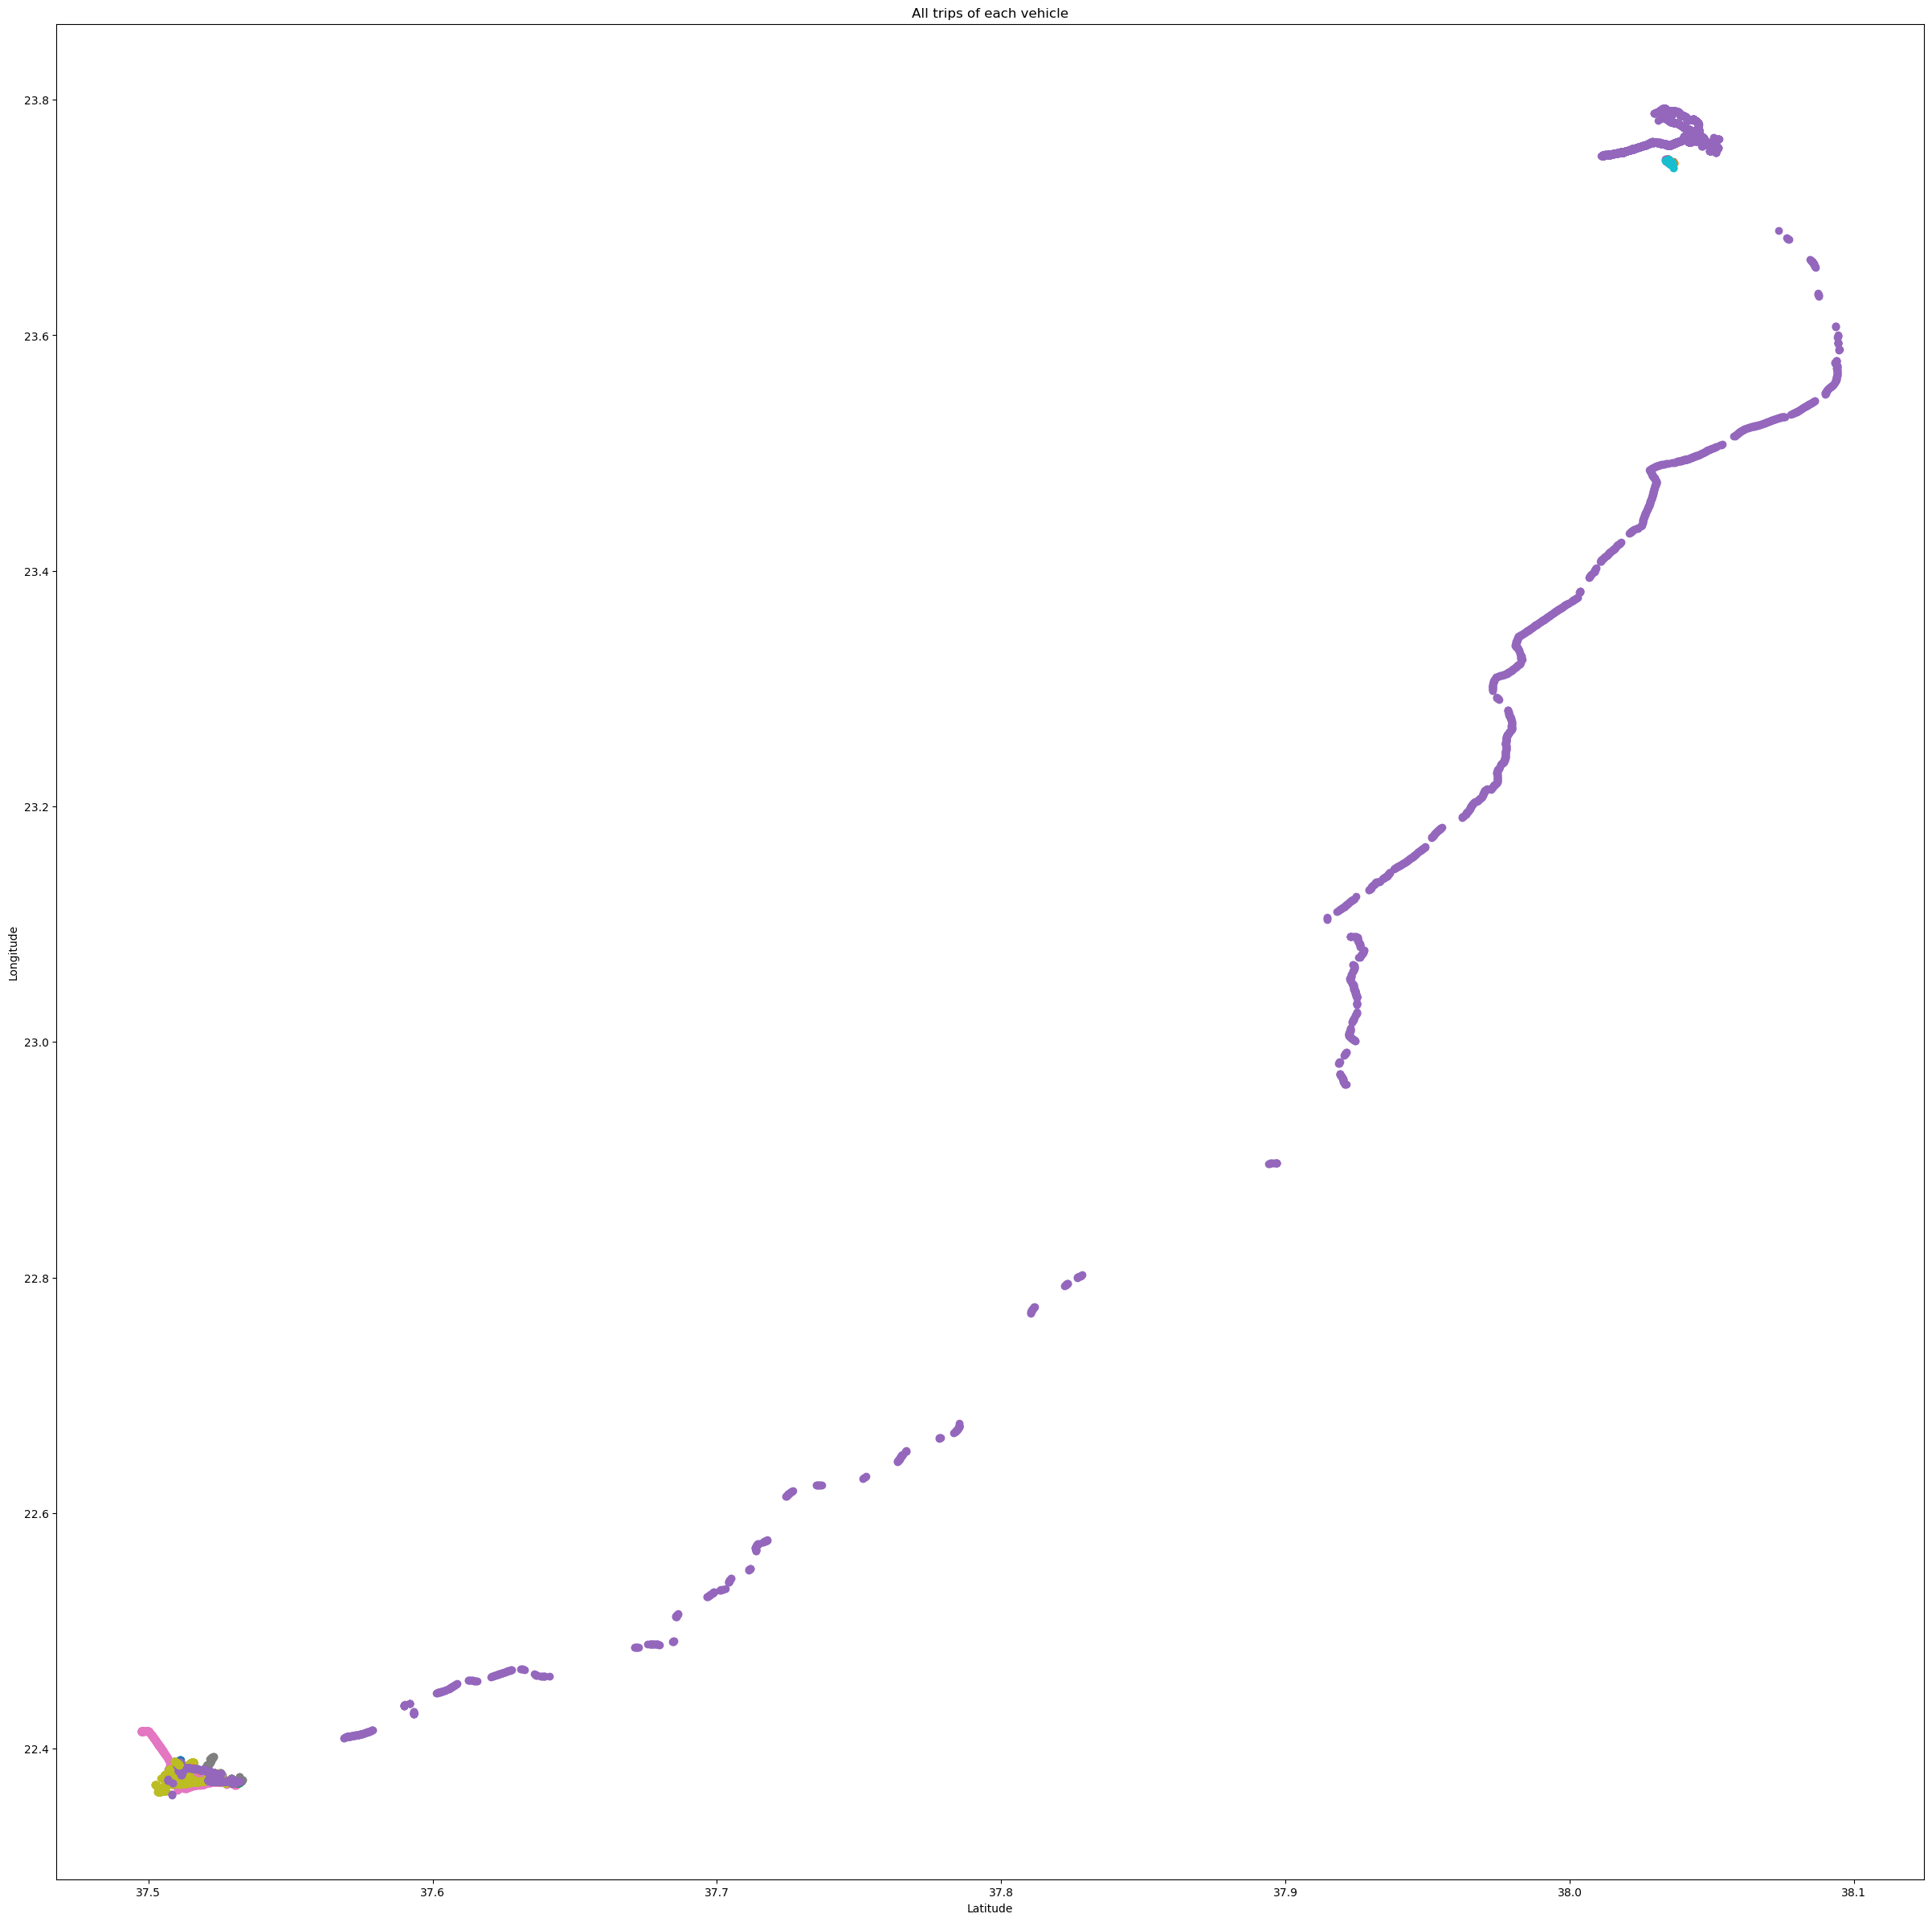

In [14]:
plt.figure(figsize=(30, 30))
plt.title('All trips of each vehicle')
for merged_dfs in ALL_merged_dfsS:
    # plt.title(f'from {date_stored.iloc[0].strftime("%Y-%m-%d")} to {date_stored.iloc[-1].strftime("%Y-%m-%d")}')
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')


    # Turn off offset notation
    plt.gca().ticklabel_format(useOffset=False)

    plt.grid()
    plt.scatter(merged_dfs['lat'], merged_dfs['lng'])
    
plt.savefig(PLOT_FOLDER_PATH, format='png')

plt.show()

In [15]:
merged_dfs.dtypes
print(merged_dfs)
print(merged_dfs['dateStored'].dtype)

    vehicleId        lat        lng     dateStored  velocity  odometer  \
0          20  38.034642  23.748100  1716383693000       0.0       0.0   
1          20  38.034573  23.748232  1716383700000      10.0       0.0   
2          20  38.034535  23.748225  1716383706000       0.0       0.0   
3          20  38.034433  23.748180  1716383761000       6.0       0.0   
4          20  38.034408  23.748237  1716383798000       0.0       0.0   
..        ...        ...        ...            ...       ...       ...   
93         20  38.034748  23.746115  1716389383000      39.0       0.0   
94         20  38.034988  23.745633  1716389387000      34.0       0.0   
95         20  38.035463  23.745138  1716389388000      33.0       0.0   
96         20  38.035783  23.744812  1716389389000      31.0       0.0   
97         20  38.036093  23.744623  1716389390000      28.0       0.0   

    engineVoltage  
0             0.0  
1             0.0  
2             0.0  
3             0.0  
4          

Plot velocity

In [73]:
plt.figure(figsize=(30, 30))
plt.title('Velocity')

for merged_dfs in ALL_merged_dfsS:
    plt.xlabel('Index')
    plt.ylabel('Velocity')
    plt.plot(merged_dfs['velocity'], marker='o', linestyle='-', color='b')
    plt.grid(True)
    
plt.savefig(plot_file_path, format='png')
plt.show()


- Calculate which the **30 degrees turns** on coordinatess
- Add <u>**orientation column for the 30 degrees turns</u>** to corresponding coordinates
- Plot the **30 degrees turns** vs velocities **before and after** making the turn

| Decimal Places | Latitude Precision (meters) | Longitude Precision (meters at Equator) |
|----------------|-----------------------------|-----------------------------------------|
| 1              | ~11,132 m                   | ~11,132 m                               |
| 2              | ~1,113 m                    | ~1,113 m                                |
| 3              | ~111.3 m                    | ~111.3 m                                |
| 4              | ~11.13 m                    | ~11.13 m                                |
| 5              | ~1.113 m                    | ~1.113 m                                |
| 6              | ~0.1113 m                   | ~0.1113 m                               |
| 7              | ~0.01113 m                  | ~0.01113 m                              |
| 8              | ~0.001113 m                 | ~0.001113 m                             |

In [ ]:
def process_coordinates(merged_dfs):
    # Load the dataset into a GeoDataFrame
    gmerged_dfs = gpd.GeoDataFrame(merged_dfs, geometry=gpd.points_from_xy(merged_dfs['lng'], merged_dfs['lat']))

    # Function to calculate precision correspondences
    def calculate_precision_distances():
        precision_list = []
        for decimals in range(1, 9):  # For 1 to 8 decimals
            latitude_precision = 111_320 / (10**decimals)  # Latitude: meters
            longitude_precision = latitude_precision  # Assuming equator (lat = 0)
            precision_list.append((decimals, latitude_precision, longitude_precision))
        return precision_list

    # Calculate precision distances
    precisions = calculate_precision_distances()

    # Create a DataFrame for output
    precision_merged_dfs = pd.DataFrame(precisions, columns=['Decimal Places', 'Latitude Precision (m)', 'Longitude Precision (m)'])
    # print(precision_merged_dfs)

    # Function to calculate the bearing between two points
    def calculate_bearing(lat1, lon1, lat2, lon2):
        """
        Calculate the bearing between two points.
        Returns the bearing in degrees.
        """
        lat1_rad, lon1_rad = math.radians(lat1), math.radians(lon1)
        lat2_rad, lon2_rad = math.radians(lat2), math.radians(lon2)

        delta_lon = lon2_rad - lon1_rad
        x = math.sin(delta_lon) * math.cos(lat2_rad)
        y = math.cos(lat1_rad) * math.sin(lat2_rad) - math.sin(lat1_rad) * math.cos(lat2_rad) * math.cos(delta_lon)
        bearing = math.atan2(x, y)
        bearing_degrees = (math.degrees(bearing) + 360) % 360  # Normalize to 0-360
        return bearing_degrees

    # Function to get orientation from bearing
    def get_orientation(bearing):
        """
        Convert a bearing in degrees to a cardinal direction.
        """
        directions = ['North', 'Northeast', 'East', 'Southeast', 'South', 'Southwest', 'West', 'Northwest']
        idx = round(bearing / 45) % 8  # Divide by 45 degrees for 8 cardinal directions
        return directions[idx]

    # Function to get the latest and next coordinate
    def get_latest_and_next_coordinates(gmerged_dfs):
        latest_coordinate = gmerged_dfs.iloc[-1]  # The last entry is the latest coordinate
        # print("Latest coordinate:", latest_coordinate)

        # Get next coordinates and calculate bearings
        next_coordinates = []
        for idx in range(len(gmerged_dfs) - 1):
            current_row = gmerged_dfs.iloc[idx]
            next_row = gmerged_dfs.iloc[idx + 1]
            bearing = calculate_bearing(current_row['lat'], current_row['lng'], next_row['lat'], next_row['lng'])
            orientation = get_orientation(bearing)
            next_coordinates.append((current_row['lat'], current_row['lng'], next_row['lat'], next_row['lng'], bearing, orientation))
        
        return latest_coordinate, next_coordinates

    # Get the latest and next coordinates
    latest_coordinate, next_coordinates = get_latest_and_next_coordinates(gmerged_dfs)

    # Print the results
    print("\nLatest Coordinate:")
    print(latest_coordinate[['lat', 'lng']])

    print("\nNext Coordinates with Orientation:")
    for coord in next_coordinates:
        print(f"Current: ({coord[0]}, {coord[1]}) -> Next: ({coord[2]}, {coord[3]}) | Bearing: {coord[4]:.2f}° | Orientation: {coord[5]}")

    return latest_coordinate, next_coordinates

def add_orientation_column(merged_dfs):
    # Function to calculate the bearing between two points
    def calculate_bearing(lat1, lon1, lat2, lon2):
        """
        Calculate the bearing between two points.
        Returns the bearing in degrees.
        """
        lat1_rad, lon1_rad = math.radians(lat1), math.radians(lon1)
        lat2_rad, lon2_rad = math.radians(lat2), math.radians(lon2)

        delta_lon = lon2_rad - lon1_rad
        x = math.sin(delta_lon) * math.cos(lat2_rad)
        y = math.cos(lat1_rad) * math.sin(lat2_rad) - math.sin(lat1_rad) * math.cos(lat2_rad) * math.cos(delta_lon)
        bearing = math.atan2(x, y)
        bearing_degrees = (math.degrees(bearing) + 360) % 360  # Normalize to 0-360
        return bearing_degrees

    # Function to get orientation from bearing
    def get_orientation(bearing):
        """
        Convert a bearing in degrees to a cardinal direction.
        """
        directions = ['North', 'Northeast', 'East', 'Southeast', 'South', 'Southwest', 'West', 'Northwest']
        idx = round(bearing / 45) % 8  # Divide by 45 degrees for 8 cardinal directions
        return directions[idx]

    # Add a new column "orientation"
    orientations = []

    # Loop through the DataFrame to calculate the bearing and orientation for each pair of consecutive coordinates
    for idx in range(len(merged_dfs) - 1):
        current_row = merged_dfs.iloc[idx]
        next_row = merged_dfs.iloc[idx + 1]
        
        # Calculate the bearing
        bearing = calculate_bearing(current_row['lat'], current_row['lng'], next_row['lat'], next_row['lng'])
        
        # Get the orientation from the bearing
        orientation = get_orientation(bearing)
        
        # Append the orientation to the list
        orientations.append(orientation)

    # For the last row, we can either leave the orientation empty or set it as "" since it has no "next" coordinate
    orientations.append("")

    # Add the "orientation" column to the DataFrame
    merged_dfs['orientation'] = orientations

    # Return the updated DataFrame
    return merged_dfs



# Assuming 'merged_dfs' is already defined as a DataFrame with columns 'lat' and 'lng'
latest_coordinate, next_coordinates = process_coordinates(merged_dfs)

# Assuming 'merged_dfs' is already defined as a DataFrame with columns 'lat' and 'lng'
merged_dfs = add_orientation_column(merged_dfs)

# Check the updated DataFrame
print(Fore.YELLOW + F"Updated DataFrame" + Style.RESET_ALL)




In [ ]:
print(merged_dfs)

- Sort the data by the **converted dateTimes**
- Plot **velocities** of <u>1 day<u/> 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# === Function to Generate All Days ===
def generate_all_days(merged_dfs):
    """
    Generates a DataFrame containing all unique days in ISO format.

    Args:
        merged_dfs (pd.DataFrame): The target DataFrame.

    Returns:
        tuple:
            - pd.DataFrame: Original data with additional 'dateOnly' column.
            - pd.DataFrame: A DataFrame containing unique days in ISO format.
    """
    try:
        # Verify required columns exist
        required_columns = ['dateStored', 'timeOnly']
        for col in required_columns:
            if col not in merged_dfs.columns:
                raise KeyError(f"Missing required column: '{col}'")

        # Convert 'dateStored' to datetime if not already done
        if not pd.api.types.is_datetime64_any_dtype(merged_dfs['dateStored']):
            merged_dfs['dateStoredHuman'] = pd.to_datetime(merged_dfs['dateStored'], unit='ms')
        
        # Extract the date-only part
        merged_dfs['dateOnly'] = merged_dfs['dateStoredHuman'].dt.date

        # Create a DataFrame with unique days
        unique_days = sorted(merged_dfs['dateOnly'].unique())
        days_df = pd.DataFrame(unique_days, columns=["Day"])
        days_df['Day'] = days_df['Day'].astype(str)  # Convert to ISO string

        return merged_dfs, days_df

    except KeyError as e:
        print(f"Error: {e}")
        return pd.DataFrame(), pd.DataFrame(columns=["Day"])
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return pd.DataFrame(), pd.DataFrame(columns=["Day"])

# === Generate All Days ===
data, df_all_days = generate_all_days(merged_dfs)

# Proceed if we have valid days
if not df_all_days.empty:
    # Select the first day
    single_day = df_all_days['Day'].iloc[0]
    single_day_data = data[data['dateOnly'] == pd.to_datetime(single_day).date()]

    if not single_day_data.empty:
        # Extract relevant columns
        time_labels = single_day_data['timeOnly']
        velocities = single_day_data['velocity'] if 'velocity' in single_day_data.columns else [0] * len(single_day_data)
        orientations = single_day_data['orientation'] if 'orientation' in single_day_data.columns else [''] * len(single_day_data)

        # Convert time_labels to strings for plotting
        time_labels_str = time_labels.astype(str)  # Convert datetime.time to string

        # Plot the velocities
        plt.figure(figsize=(15, 10))
        plt.plot(time_labels_str, velocities, marker='o', linestyle='-', color='b')

        # Annotate orientation labels
        for i, txt in enumerate(orientations):
            if pd.notna(txt):  # Only label non-null orientations
                plt.text(time_labels_str[i], velocities.iloc[i], f'{txt}', ha='left', va='bottom', fontsize=9)

        plt.title(f"Velocities on {single_day}", fontsize=16)
        plt.xlabel('Time (HH:MM:SS)', fontsize=14)
        plt.ylabel('Velocity', fontsize=14)
        plt.xticks(rotation=45)
        plt.grid(True)

        # Save and show the plot
        plot_filename = os.path.join("plots", f'{single_day}_velocities.png')
        os.makedirs(os.path.dirname(plot_filename), exist_ok=True)
        plt.savefig(plot_filename)
        print(f"Plot saved as {plot_filename}")

        plt.show()

    else:
        print(f"No data available for the selected day: {single_day}")
else:
    print("No unique days found in the dataset.")


Plot <u>velocities, orientations</u> **on** <u>coordinates</u>>

In [ ]:
plt.figure(figsize=(20, 10))
plt.xlabel('Latitude')
plt.ylabel('Longitude')
# Turn off offset notation
plt.gca().ticklabel_format(useOffset=False)
plt.grid()
scatter = plt.scatter(merged_dfs['lat'], merged_dfs['lng'], c=merged_dfs['velocity'], cmap='viridis', s=100, edgecolors='k')
#* Add color bar
colorbar = plt.colorbar(scatter)
colorbar.set_label('Velocities')

plt.show()

In order to finish, **update** the "all_vehicle_responses.csv" with the DataFrame

In [ ]:
all_vehicles_data_path = "../../DataSets/API_Responses/Vehicle_Data/all_vehicle_responses.csv"
merged_dfs.to_csv(all_vehicles_data_path, index=False)
print(f"DataFrame stored to {all_vehicles_data_path}")